In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2023-11-21 13:36:12.661567: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 13:36:12.936668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 13:36:12.936726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 13:36:12.937063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 13:36:13.015625: I tensorflow/core/platform/cpu_feature_g

2.14.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-21 13:36:19.516955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-21 13:36:19.607396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-21 13:36:19.607459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Step 1: Load Rainfall Images and GPS Data

In [15]:
from math import cos
import os
from PIL import Image
import pandas as pd
import numpy as np

# Define paths to your data
images_folder = 'data/output_images/WB_migrant'
gps_file = 'data/Serengeti_all.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date'].dt.date

gps_data = gps_data.sort_values(by=['ID','date'])

#calculate differences per day and group by ID
gps_data['x_diff'] = gps_data.groupby('ID')['x1_'].diff().fillna(0)
gps_data['y_diff'] = gps_data.groupby('ID')['y1_'].diff().fillna(0)

#gps_data['cta_'] = np.cos(gps_data['ta_'])

# Display the first few rows of the GPS data
print(gps_data.head())

# Create an empty list to store image-GPS pairs
data = []

# Load images and corresponding GPS data
for index, row in gps_data.iterrows():
    image_path = os.path.join(images_folder, f"image_{index}.jpg")  # Assuming images are named with corresponding indices
    image = Image.open(image_path)
    gps_info = row[['x_diff', 'y_diff']].tolist()
    data.append((image, gps_info))



          ID          x1_          x2_          y1_          y2_          sl_  \
27368  SW100  685184.3605  680764.8743  9723333.494  9724120.192  4488.958901   
27379  SW100  680764.8743  674933.7549  9724120.192  9728178.122  7104.136073   
27390  SW100  674933.7549  675019.5210  9728178.122  9727439.122   743.960230   
27401  SW100  675019.5210  673586.9019  9727439.122  9726742.822  1592.868851   
27412  SW100  673586.9019  669799.8705  9726742.822  9723233.359  5163.132516   

            ta_ species       lat       long  ... step_id_   cos_ta_  \
27368 -0.341631      WB -2.504718  34.666306  ...        3  0.942210   
27379 -0.431814      WB -2.497654  34.626559  ...        4  0.908208   
27390  2.294312      WB -2.461019  34.574084  ...        5 -0.662023   
27401 -1.233925      WB -2.467701  34.574863  ...        6  0.330536   
27412  0.294964      WB -2.474014  34.561989  ...        7  0.956813   

        log_sl_ sl_dist_shape sl_dist_scale  ta_dist_kappa ta_dist_mu  \
27368  

Step 2: Preprocess Images and Combine with GPS Data

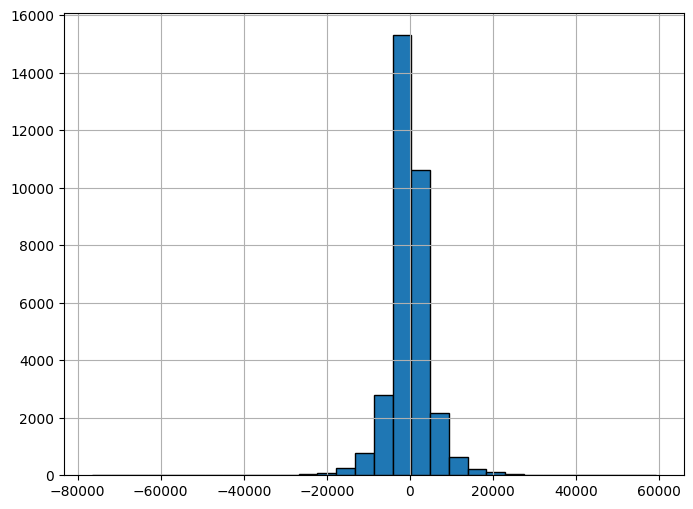

In [27]:
import matplotlib.pyplot

plt.figure(figsize=(8,6))
plt.hist(gps_data['x_diff'], bins=30, edgecolor='black')
plt.grid(True)
plt.show()

In [16]:
# Resize and normalize images
data = [(np.array(image.resize((32, 32))) / 255.0, gps_info) for image, gps_info in data]

# Separate data back into images and GPS information
X_images = np.array([item[0] for item in data])
X_gps = np.array([item[1] for item in data])

# Assuming 'gps_lat' and 'gps_lon' are the columns for latitude and longitude
y_gps_x = gps_data['x_diff'].values
y_gps_y = gps_data['y_diff'].values

y_coordinates = gps_data[['x_diff', 'y_diff']].values


In [8]:
X_images

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

View the first 9 images

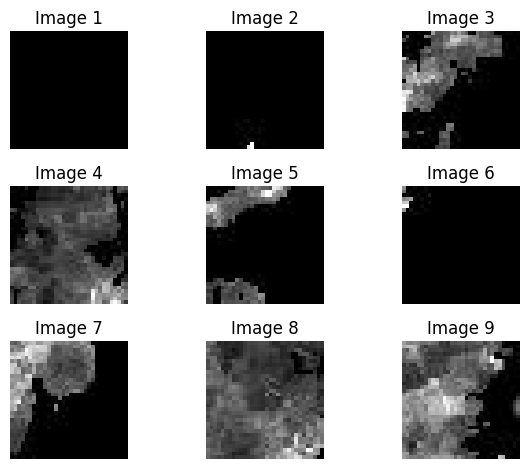

In [9]:
import matplotlib.pyplot as plt

# Assuming X_images is a numpy array containing the images
for i in range(min(9, X_images.shape[0])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_images[i], cmap='gray')  # Assuming images are grayscale
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [17]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# y_train_coordinates = df[['x_diff', 'y_diff']].values

X_images_train, X_images_test, X_gps_train, X_gps_test, y_train_coordinates, y_test_coordinates = train_test_split(X_images, X_gps, y_coordinates, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("Training set shapes - X_images_train:", X_images_train.shape, "y_train_coordinates:", y_train_coordinates.shape )
print("Testing set shapes - X_images_test:", X_images_test.shape, "y_test_coordinates:", y_test_coordinates.shape)



Training set shapes - X_images_train: (26531, 32, 32) y_train_coordinates: (26531, 2)
Testing set shapes - X_images_test: (6633, 32, 32) y_test_coordinates: (6633, 2)


Step 3: Model-Specific Preprocessing

In [28]:
from tensorflow.keras import layers, models

# Define your model
image_input = layers.Input(shape=(32, 32, 1), name='image_input')
#gps_input = layers.Input(shape=(2,), name='gps_input')

# Image processing branch
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

# GPS information processing branch
y = layers.Dense(64, activation='relu')(gps_input)

# Combine the branches
combined = layers.concatenate([x, y])

# Output layer for turning angle prediction
gps_output = layers.Dense(2, activation='linear', name='gps_output')(x)  # Assuming 2 coordinates (latitude, longitude)


# Define the model with multiple inputs
#model = models.Model(inputs=[image_input, gps_input], outputs=output)
#model = models.Model(inputs=[image_input, gps_input], outputs=[gps_output])
model = models.Model(inputs=[image_input], outputs=[gps_output])

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate decay function
def learning_rate_scheduler(epoch, lr):
    return lr * 0.95  # Adjust the decay factor as needed

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Compile the model with an initial learning rate
initial_learning_rate = 0.001
opt = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=opt, loss={'gps_output': 'mean_squared_error'}, metrics={'gps_output': 'mae'})

# Display the model summary
model.summary()

#


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                460864    
                                                                 
 gps_output (Dense)          (None, 2)                 130       
                                                           

Step 4: Model Training

In [30]:
# Train the model with learning rate decay
#model.fit([X_images_train, X_gps_train], {'gps_output': np.column_stack((y_gps_x_train, y_gps_y_train))}, 
 #         epochs=10, validation_data=([X_images_test, X_gps_test], {'gps_output': np.column_stack((y_gps_x_test, y_gps_y_test))}),
  #        callbacks=[lr_scheduler])

#model.fit([X_images_train, X_gps_train], y_train_coordinates, epochs=10, validation_data=([X_images_test, X_gps_test], {'gps_output': y_test_coordinates}),
 #         callbacks=[lr_scheduler])

model.fit(X_images_train, y_train_coordinates, epochs=10, validation_data=(X_images_test, {'gps_output': y_test_coordinates}),
          callbacks=[lr_scheduler])


Epoch 1/10
830/830 [==============================] - 18s 19ms/step - loss: 25124126.0000 - mae: 3021.9023 - val_loss: 26089580.0000 - val_mae: 3080.6038 - lr: 9.5000e-04
Epoch 2/10
830/830 [==============================] - 16s 20ms/step - loss: 25041540.0000 - mae: 3024.4287 - val_loss: 26079946.0000 - val_mae: 3086.8894 - lr: 9.0250e-04
Epoch 3/10
830/830 [==============================] - 17s 20ms/step - loss: 25020842.0000 - mae: 3025.1736 - val_loss: 26090738.0000 - val_mae: 3095.2852 - lr: 8.5737e-04
Epoch 4/10
830/830 [==============================] - 17s 20ms/step - loss: 25011342.0000 - mae: 3027.0728 - val_loss: 26068152.0000 - val_mae: 3087.9419 - lr: 8.1451e-04
Epoch 5/10
830/830 [==============================] - 18s 21ms/step - loss: 24996018.0000 - mae: 3026.1682 - val_loss: 26063980.0000 - val_mae: 3087.8765 - lr: 7.7378e-04
Epoch 6/10
830/830 [==============================] - 17s 20ms/step - loss: 24983124.0000 - mae: 3027.0266 - val_loss: 26055166.0000 - val_mae: 3

Step 5: Model Evaluation

In [32]:
# Evaluate the model on the test set
#losses = model.evaluate([X_images_test, X_gps_test], {'gps_output': y_test_coordinates})
losses = model.evaluate(X_images_test, {'gps_output': y_test_coordinates})


# Extract individual losses
total_loss = losses[0]
gps_loss = losses[1]

print(f'Test Total Loss: {total_loss}')
print(f'Test GPS Loss: {gps_loss}')


208/208 [==============================] - 3s 12ms/step - loss: 26044206.0000 - mae: 3086.8193
Test Total Loss: 26044206.0
Test GPS Loss: 3086.8193359375


208/208 [==============================] - 1s 6ms/step


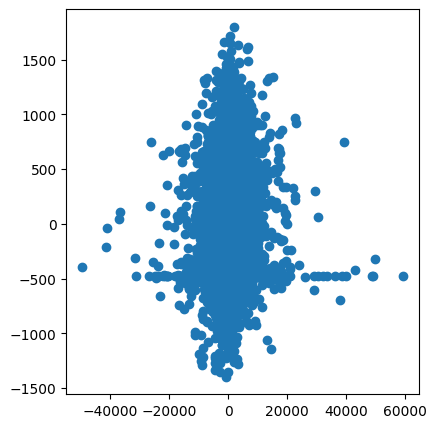

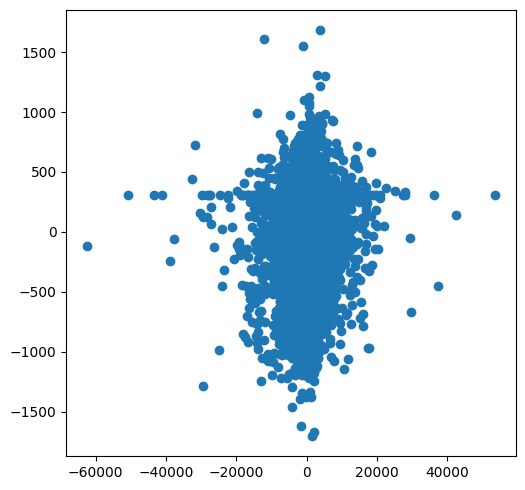

In [35]:
import matplotlib.pyplot as plt

#predictions = model.predict([X_images_test,X_gps_test])
predictions = model.predict(X_images_test)

#Scatter plot for actual vs. predicted x differences
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test_coordinates[:,0], predictions[:,0])
#plt.xlim([-10000,10000])
#plt.ylim([-10000,10000])

#Scatter plot for actual vs. predicted x differences
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test_coordinates[:,1], predictions[:,1])
#plt.xlim([-10000,10000])
#plt.ylim([-10000,10000])

plt.tight_layout()
plt.show()

